# COMP4211 PA1

Name: *redacted*  
SID: *redacted*  


First, we'll import some common libraries and datasets.

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

colab = True
plotting = True
plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

In [223]:
# Load data.
if colab:
    # Import from online repo, since Google Colab keeps refreshing its filesystem.
    df_train = pd.read_csv('https://raw.githubusercontent.com/TrebledJ/hkust/master/comp4211/pa1/data/train.csv')
    df_test = pd.read_csv('https://raw.githubusercontent.com/TrebledJ/hkust/master/comp4211/pa1/data/test.csv')
else:
    df_train = pd.read_csv('data/train.csv')
    df_test = pd.read_csv('data/test.csv')

df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,label
0,120,RL,34.0,5381,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,8,2009,WD,Normal,196000,1
1,20,RL,57.0,9764,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2008,WD,Normal,130000,0
2,60,RL,130.0,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,10,2007,New,Partial,184750,1
3,20,RL,NaN,8125,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2006,WD,Normal,230000,1
4,60,RL,NaN,10832,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,500,10,2008,WD,Normal,194500,1


We'll define some helper functions so that future code is cleaner.

In [186]:
def print_metric(metric: str, data, *, dp=6, unit='', col=[20, 10]):
    """Helper function for pretty-printing a metric summary (mean / std)."""
    if isinstance(data, (int, float)):
        if unit == '%':
            data *= 100
        print(f' - {metric:{col[0]}} {data:.{dp}f}{unit}')
    else:
        mean = np.mean(np.array(data))
        std = np.std(np.array(data))
        if unit == '%':
            mean *= 100
            std *= 100
        means = f'{mean:.{dp}f}{unit}'
        print(f' - {metric:{col[0]}} µ={means:{col[1]}} / std={std:.{dp}f}{unit}')

# Part 1: Data Processing

## Q1: Preprocessing

First, we'll clean up our messy data by filling NaN values with the median of a column (for numeric columns) and `"None"` (for non-numeric columns).

In [157]:
def preprocess(df):
    df = df.drop_duplicates()
    # Fill na in numeric columns with median.
    df = df.fillna(df.median(numeric_only=True))
    # Fill na in string columns with "None".
    return df.fillna("None")

df_train = preprocess(df_train)
df_test = preprocess(df_test)

Once we've preprocessed our data, we combine the training and test data. This is done so that all enumerations are visible within a column, and so `pd.get_dummies` will create columns for all enumerations.

In [158]:
df_all = pd.concat([df_train, df_test])

# One-hot encoding.
df_ohe = pd.get_dummies(df_all, drop_first=True) # TODO: Why use drop_first?
assert len(df_ohe.columns) == 244 and 'label' in df_ohe and 'SalePrice' in df_ohe

# Re-split training/test data for next stage.
df_train2, df_test2 = df_ohe.iloc[:len(df_train)], df_ohe.iloc[len(df_train):]

### Feature Scaling
The purpose of **feature scaling** is to normalise data, so that one column doesn't "weigh" more than others due to their magnitude.

We'll scale everything except SalePrice and label—which, for the purpose of this assignment, are considered output variables.

In [222]:
from sklearn.preprocessing import StandardScaler

# Feature scaling.
X_train = df_train2.drop(['SalePrice', 'label'], axis=1)
sc = StandardScaler()
sc.fit(X_train)
X_train = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)
y_train = df_train2[['SalePrice', 'label']]

# Scale test data also.
X_test = df_test2.drop(['SalePrice', 'label'], axis=1)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)
y_test = df_test2[['SalePrice', 'label']]

X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.525294,-1.672075,-0.462368,-0.069658,-0.512573,1.122442,0.976786,0.197350,0.973572,-0.301983,...,-0.054855,-0.054855,-0.308691,-0.044766,0.398433,-0.044766,-0.089803,-0.114766,0.474858,-0.314485
1,-0.868638,-0.617428,-0.068822,-0.802898,1.311531,-0.146571,0.880456,-0.568299,0.551690,-0.301983,...,-0.054855,-0.054855,-0.308691,-0.044766,0.398433,-0.044766,-0.089803,-0.114766,0.474858,-0.314485
2,0.088935,2.729933,2.654482,2.863304,-0.512573,1.189232,1.121281,3.753364,3.871340,-0.301983,...,-0.054855,-0.054855,3.239483,-0.044766,-2.509835,-0.044766,-0.089803,-0.114766,-2.105892,3.179797
3,-0.868638,-0.021322,-0.215987,0.663583,-0.512573,1.022256,0.832291,1.104786,1.156813,-0.301983,...,-0.054855,-0.054855,-0.308691,-0.044766,0.398433,-0.044766,-0.089803,-0.114766,0.474858,-0.314485
4,0.088935,-0.021322,0.027073,0.663583,-0.512573,0.755096,0.543301,-0.568299,-0.944070,-0.301983,...,-0.054855,-0.054855,-0.308691,-0.044766,0.398433,-0.044766,-0.089803,-0.114766,0.474858,-0.314485


## Q2: Heatmap Correlation
A useful visual aid for checking correlations between columns is the heatmap.

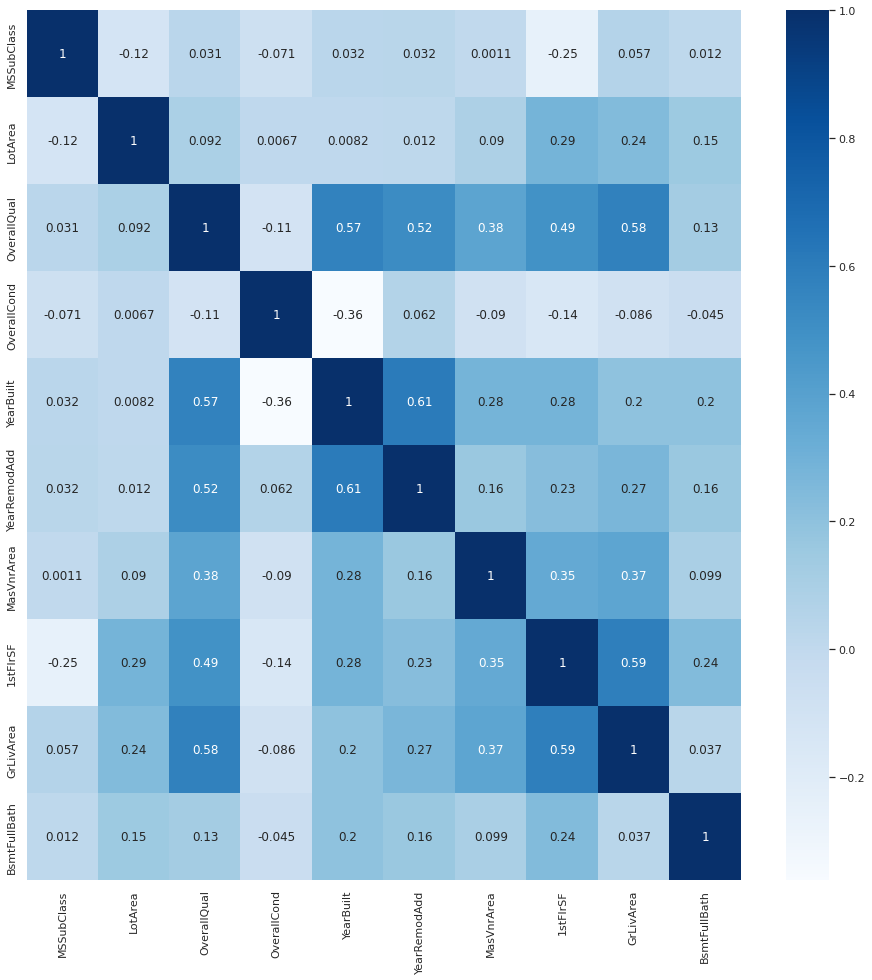

In [237]:
# Plot correlation among first ten features.
if plotting:
    sns.heatmap(X_train.iloc[:, :10].corr(), annot=True, cmap='Blues')
    plt.show()

# Part 2: Feature Selection

## Q3: Feature Selection with Linear Regression/Lasso

To reduce the computational cost and remove irrelevant features, we would like to choose a subset of features for the subsequent tasks.

We'll select the features that most correlate with SalePrice. To do this, we use `SelectFromModel` and provide an estimator. We'll try use two different selection strategies by using different estimators:

1. `LinearRegression`
2. `Lasso`, with `alpha=0.005` and `random_state=4211`.

After selecting features, we'll train a LinearRegression model to fit those features against the SalePrice. Using the trained model, we verify the model using test data.

In [225]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

def q3_select_and_train(estimator):
    """
    Filter strong features correlated against SalePrice.
    Then train a model using those features to predict SalePrice.
    """
    # Train all features against SalePrice.
    selector = SelectFromModel(estimator).fit(X_train, np.log(y_train['SalePrice']))

    # Select the "most important" features, discarding the rest.
    X = selector.transform(X_train)

    # Train selected features against SalePrice, to be able to predict SalePrice using said features.
    model = LinearRegression().fit(X, y_train['SalePrice'])
    
    r2 = r2_score(y_test['SalePrice'], model.predict(selector.transform(X_test)))
    return selector, model, r2

sel_lr, model_lr, r2_lr = q3_select_and_train(LinearRegression())
sel_las, model_las, r2_las = q3_select_and_train(Lasso(alpha=0.005, random_state=4211))

print('--- Feature Selection ---')
print(f'{"estimator=LinearRegression():":30}{r2_lr:.6f}')
print(f'{"estimator=Lasso():":30}{r2_las:.10f}')
print()
if r2_lr > r2_las:
    selector = sel_lr
else:
    selector = sel_las

print('--- Selected Columns ---')
X_train.columns[selector.get_support()]

--- Feature Selection ---
estimator=LinearRegression(): 0.692034
estimator=Lasso():            0.8857060189

--- Selected Columns ---


Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_RL',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Lvl',
       'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_Inside',
       'LandSlope_Mod', 'Neighborhood_BrDale', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Sawyer', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA',
       'Condition1_RRAe', 'Condition2_PosN', 'BldgType_2fmCon',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'RoofMat

In [226]:
X_train = pd.DataFrame(selector.transform(X_train), columns=X_train.columns[selector.get_support()])
X_test = pd.DataFrame(selector.transform(X_test), columns=X_test.columns[selector.get_support()])

X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,GrLivArea,BsmtFullBath,...,GarageFinish_Unf,GarageQual_None,GarageCond_Fa,GarageCond_None,PavedDrive_Y,SaleType_CWD,SaleType_New,SaleCondition_AdjLand,SaleCondition_Family,SaleCondition_Normal
0,1.525294,-0.462368,-0.069658,-0.512573,1.122442,0.976786,0.197350,0.341039,-0.385992,1.143839,...,-0.831894,-0.245856,-0.160128,-0.245856,0.294884,-0.063372,-0.308691,-0.044766,-0.114766,0.474858
1,-0.868638,-0.068822,-0.802898,1.311531,-0.146571,0.880456,-0.568299,-0.699276,-1.164670,1.143839,...,-0.831894,-0.245856,-0.160128,-0.245856,0.294884,-0.063372,-0.308691,-0.044766,-0.114766,0.474858
2,0.088935,2.654482,2.863304,-0.512573,1.189232,1.121281,3.753364,4.966904,5.983292,1.143839,...,-0.831894,-0.245856,-0.160128,-0.245856,0.294884,-0.063372,3.239483,-0.044766,-0.114766,-2.105892
3,-0.868638,-0.215987,0.663583,-0.512573,1.022256,0.832291,1.104786,1.219751,0.271727,1.143839,...,1.202076,-0.245856,-0.160128,-0.245856,0.294884,-0.063372,-0.308691,-0.044766,-0.114766,0.474858
4,0.088935,0.027073,0.663583,-0.512573,0.755096,0.543301,-0.568299,-0.214469,0.727215,-0.801465,...,-0.831894,-0.245856,-0.160128,-0.245856,0.294884,-0.063372,-0.308691,-0.044766,-0.114766,0.474858


# Part 3: Regression

## Q4: $R^2$ Correlation for LotArea, GrLivArea, OverallQual, and OverallCond

In [163]:
from sklearn.model_selection import train_test_split
from collections import namedtuple

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=4211)
# X = pd.DataFrame(selector.transform(X_train), columns=X_train.columns[selector.get_support()])
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_train, train_size=0.8, random_state=4211)

Q4Report = namedtuple('Report', ['model', 'r2'])

def q4_report(feature):
    model = LinearRegression().fit(X_train2[feature].to_frame(), y_train2['SalePrice'])
    r2 = r2_score(y_test2['SalePrice'], model.predict(X_test2[feature].to_frame()))
    return Q4Report(model, r2)

part3_features = ['LotArea', 'GrLivArea', 'OverallQual', 'OverallCond']
part3 = {}
print('--- Validation R2 Correlation ---')
for feat in part3_features:
    part3[feat] = q4_report(feat)
    print(f'{feat:30}{part3[feat].r2:.6f}')

--- Validation R2 Correlation ---
LotArea                       0.020534
GrLivArea                     0.392684
OverallQual                   0.586950
OverallCond                   0.017107


## Q5: Correlation Plots

We'll plot four graphs to observe the trends and correlation between the four selected features above.

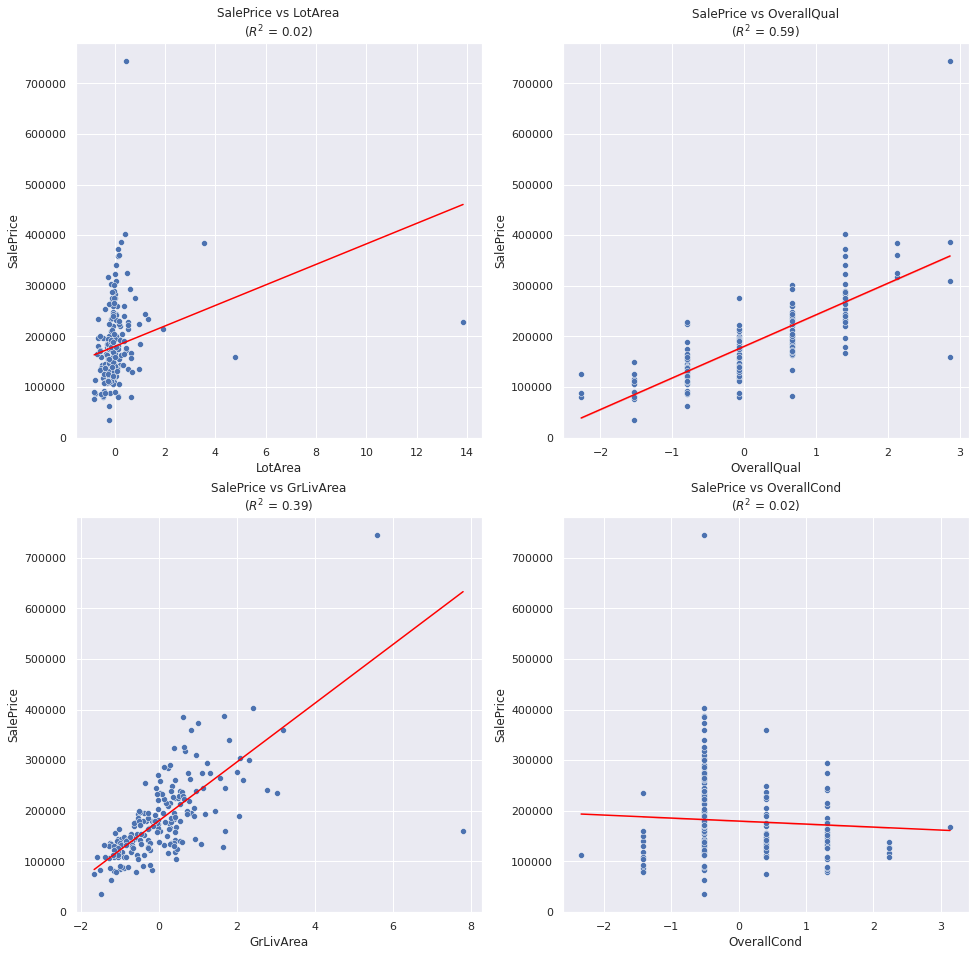

In [164]:
if plotting:
    sns.set()
    sns.set_palette("deep")
    fig, axs = plt.subplots(2, 2)
    for i, feat in enumerate(part3_features):
        X = X_test2[feat]
        p = sns.scatterplot(x=X, y=y_test2['SalePrice'], ax=axs[i%2, i//2])
        p.set_title(f'SalePrice vs {feat}\n($R^2$ = {part3[feat].r2:.2f})')
        sns.lineplot(x=X, y=part3[feat].model.predict(X.to_frame()), ax=axs[i%2, i//2], color='red')
    fig.show()

We build our 5th linear regression model to explore the relationship between the features selected in [Q3](#scrollTo=vjk25C9Ikp-V) and SalePrice. We'll also compute the training time for later use in [Q7](#scrollTo=rej7CwA_kp-z).

<!-- https://piazza.com/class/l71avavtm4d2xl/post/59 -->

In [189]:
import time

X = X_train2
y = y_train2['SalePrice']

start = time.time()
model = LinearRegression().fit(X, y)
q5_train_time = time.time() - start   # Elapsed time used later in Q7.

X = X_test2
y = y_test2['SalePrice']
q5_r2 = r2_score(y, model.predict(X))

print('--- X vs. SalePrice ---')
print_metric('r2', q5_r2)

--- X vs. SalePrice ---
 - r2                   0.687175


## Q6: Regression + FNN

To find the optimal number of hidden units for a six-layer FNN, we'll try 8 different hidden units $h$ per layer, for $h \in \{1, 2, 4, 8, 16, 32, 64, 128\}$. For each size, we'll construct an `MLPRegressor` model and collect performance data (fit time and $R^2$ score).

In [219]:
import time
from sklearn.neural_network import MLPRegressor

units = [1, 2, 4, 8, 16, 32, 64, 128]   # Different units to be tried.
random_states = [4211, 3300, 4901]      # Fixed set of random states.

settings = [{"hidden_layer_sizes": (h, h, h, h, h, h), "max_iter": 500, "early_stopping": True} for h in units]
times = []  # Collect data across different params.
r2s = []

X = X_train2
y = y_train2['SalePrice']
X_val = X_test2
y_val = y_test2['SalePrice']

def linear_regression(params):
    ts, rs = [], []
    for rand in random_states:
        rgr = MLPRegressor(random_state=rand, **params)
        
        start = time.time()
        rgr.fit(X.to_numpy(), y)
        elapsed = time.time() - start

        r2 = r2_score(y_val, rgr.predict(X_val.to_numpy()))
        # r2_train = r2_score(y, rgr.predict(X.to_numpy()))  # Uncomment to see underfit.
        # print(r2_train, r2)

        ts += [elapsed]
        rs += [r2]

    return ts, rs

for st in settings:
    ts, rs = linear_regression(st)
    times += [ts]
    r2s += [rs]

After collecting our training time and $R^2$ data, we can process it to find the mean/std training time and $R^2$ score.

Observe that for sizes 1 to 16, the $R^2$ score is negative, whereas for 32 and above, the score rests comfortably in the 0.63-0.66 range.

See [Q8](#scrollTo=3fEBzInikp-z) for a graphical presentation.

In [220]:
# Print settings and mean/std performance metrics of each model.
for h, st, t, r2 in zip(units, settings, times, r2s):
    print(f'--- Number of Hidden Units: {h} ---')
    print(f'Model Settings: {st}')
    print(f'Metrics:')
    print_metric("training time", t, dp=3, unit='s')
    print_metric("r2", r2)
    print()

--- Number of Hidden Units: 1 ---
Model Settings: {'hidden_layer_sizes': (1, 1, 1, 1, 1, 1), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time        µ=0.164s     / std=0.025s
 - r2                   µ=-5.226463  / std=0.000103

--- Number of Hidden Units: 2 ---
Model Settings: {'hidden_layer_sizes': (2, 2, 2, 2, 2, 2), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time        µ=0.115s     / std=0.034s
 - r2                   µ=-5.226587  / std=0.000024

--- Number of Hidden Units: 4 ---
Model Settings: {'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time        µ=0.094s     / std=0.006s
 - r2                   µ=-5.226493  / std=0.000057

--- Number of Hidden Units: 8 ---
Model Settings: {'hidden_layer_sizes': (8, 8, 8, 8, 8, 8), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time        µ=0.116s     / std=0.024s
 - r2                   µ=-5.226417  / std=0.000019

--- Number of Hi

## Q7

In [221]:
# Find NN with best R2 score.
st, rand, t_nn, r2_nn = max(((st, rand, t, sample) for st, ts, r2 in zip(settings, times, r2s) for rand, t, sample in zip(random_states, ts, r2)), key=lambda x: x[-1])

print('--- Linear Regression Model ---')
print_metric("training time", q5_train_time, dp=3, unit='s')
print_metric("r2", q5_r2)
print()
print('--- FNN Model ---')
print(f'Model Settings: {st}')
print(f'random_state: {rand}')
print_metric("training time", t_nn, dp=3, unit='s')
print_metric("r2", r2_nn)

--- Linear Regression Model ---
 - training time        0.034s
 - r2                   0.687175

--- FNN Model ---
Model Settings: {'hidden_layer_sizes': (64, 64, 64, 64, 64, 64), 'max_iter': 500, 'early_stopping': True}
random_state: 3300
 - training time        4.445s
 - r2                   0.683298


Overall, the linear regression model did better. It has a much shorter training time due to less weights. The $R^2$ score of both models is pretty close. I would've expected the FNN model to perform better, but maybe this is just due to randomness.

## Q8
We use `np.mean(..., axis=1)` to compute the mean for each $h$.

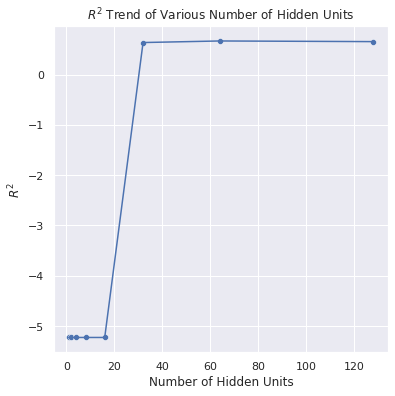

In [181]:
time_mean = np.mean(np.array(times), axis=1)
r2_mean = np.mean(np.array(r2s), axis=1)

if plotting:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=units, y=r2_mean)
    plot = sns.lineplot(x=units, y=r2_mean)
    plot.set_title("$R^2$ Trend of Various Number of Hidden Units")
    plot.set_xlabel("Number of Hidden Units")
    plot.set_ylabel("$R^2$")
    plt.show()

Yes, a trend exists, as after a threshold (16 to 32 units per layer), the FNN begins to function well with $R^2 > 0.6$. However, after 32 units, the $R^2$ becomes saturated and doesn't show too many signs of improvement.

Perhaps the trend is due to underfitting in the earlier stages. If we compute and print the $R^2$ training scores in the Q6 code, we can see that the values are quite low ($< 0$), indicating an underfit.

As we increase the number of hidden units, we increase the number of weights and parameters, and the model is able to learn better.

However, there is not much change after 32 units as perhaps some units become redundant and saturated.

# Part 4: Classification

## Q9: Classification Model Tuning

For this question, we try different sets of parameters for `SGDClassifier` (which uses stochastic gradient descent). In particular, I'm intersted in trying different learning rates.

The metrics we're interested in are training time, accuracy, and F1.

In [205]:
import time
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

def logistic_metrics(y_test, y_pred):
    acc = metrics.accuracy_score(y_test, y_pred)
    pre = metrics.precision_score(y_test, y_pred, zero_division=0)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    return {"acc": acc, "pre": pre, "rec": rec, "f1": f1}

def logistic_regression(*, random_states=random_states, **params):
    performance = []
    for rand in random_states:
        model = SGDClassifier(loss='log' if colab else 'log_loss', random_state=rand, **params)

        start = time.time()
        model.fit(X_train2, y_train2['label'])
        training_time = time.time() - start
        
        ms = logistic_metrics(y_test2['label'], model.predict(X_test2))
        ms['time'] = training_time
        performance.append(ms)

    performance = pd.DataFrame(performance)
    print('--- LogisticRegression ---')
    print(f'SGDClassifier: {params}')
    print(f'Metrics:')
    print_metric("training time", performance['time'], dp=3, unit='s')
    print_metric("accuracy", performance['acc'], dp=1, unit='%')
    # print_metric("precision", performance['pre'], dp=1, unit='%')
    # print_metric("recall", performance['rec'], dp=1, unit='%')
    print_metric("F1", performance['f1'], dp=1, unit='%')
    print()
    return performance

logistic_regression(eta0=0.1, learning_rate='constant')
# logistic_regression(eta0=0.01, learning_rate='optimal')
logistic_regression(eta0=0.1, learning_rate='optimal', alpha=0.05)
# q9_perf = logistic_regression(eta0=0.1, learning_rate='invscaling')
logistic_regression(eta0=0.2, learning_rate='invscaling')
# logistic_regression(eta0=0.3, learning_rate='invscaling')
q9_perf = logistic_regression(eta0=0.4, learning_rate='invscaling')
# logistic_regression(eta0=0.1, learning_rate='invscaling', power_t=0.4)
# logistic_regression(eta0=0.1, learning_rate='invscaling', power_t=0.6)


--- LogisticRegression ---
SGDClassifier: {'eta0': 0.1, 'learning_rate': 'constant'}
Metrics:
 - training time        µ=0.022s     / std=0.010s
 - accuracy             µ=92.3%      / std=0.8%
 - F1                   µ=90.6%      / std=0.9%

--- LogisticRegression ---
SGDClassifier: {'eta0': 0.1, 'learning_rate': 'optimal', 'alpha': 0.05}
Metrics:
 - training time        µ=0.023s     / std=0.002s
 - accuracy             µ=92.2%      / std=0.2%
 - F1                   µ=90.2%      / std=0.2%

--- LogisticRegression ---
SGDClassifier: {'eta0': 0.2, 'learning_rate': 'invscaling'}
Metrics:
 - training time        µ=0.035s     / std=0.004s
 - accuracy             µ=92.8%      / std=0.2%
 - F1                   µ=91.2%      / std=0.3%

--- LogisticRegression ---
SGDClassifier: {'eta0': 0.4, 'learning_rate': 'invscaling'}
Metrics:
 - training time        µ=0.030s     / std=0.001s
 - accuracy             µ=93.2%      / std=0.2%
 - F1                   µ=91.5%      / std=0.3%



## Q10: Confusion Matrix

true negative: 110
false positive: 10
false negative: 6
true positive: 74



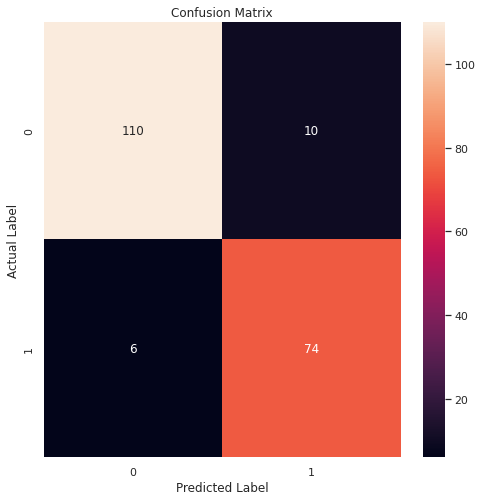

In [207]:
from sklearn.metrics import confusion_matrix

sgd = SGDClassifier(loss='log' if colab else 'log_loss', random_state=4901, eta0=0.1, learning_rate='invscaling')
sgd.fit(X_train2, y_train2['label'])
cnf_matrix = confusion_matrix(y_test2['label'], sgd.predict(X_test2))
[[tn, fp], [fn, tp]] = cnf_matrix
print(f'true negative: {tn}')
print(f'false positive: {fp}')
print(f'false negative: {fn}')
print(f'true positive: {tp}')
print()

if plotting:
    plt.figure(figsize=(8, 8))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

A reason for looking at the true/false positive/negative is that these numbers help us determine whether a model is useful or not for correct labelling.

Sometimes it is better to look at the precision or recall. For example, if we have TP=5, FP=5, FN=5, TN=85, then we have a 90% accuracy; but looking only at the positive labels, only 50% succeeded.

Thus, separating the results into these four categories is important.

## Q11: Classification + FNN

In [209]:
import time
from sklearn.neural_network import MLPClassifier

def logistic_fnn(**params):
    """Trains several classifiers and computes performance metrics."""
    performance = []
    params.update(max_iter=500, early_stopping=True)
    for rand in random_states:
        model = MLPClassifier(random_state=rand, **params)
        
        start = time.time()
        model.fit(X_train2.to_numpy(), y_train2['label'])
        training_time = time.time() - start

        ms = logistic_metrics(y_test2['label'], model.predict(X_test2.to_numpy()))
        ms['time'] = training_time
        performance.append(ms)
    
    performance = pd.DataFrame(performance)
    params.update()
    print('--- Logistic Regression (FNN) ---')
    print(f'MLPClassifier: {params}')
    print(f'Metrics:')
    print_metric("training time", performance['time'], dp=3, unit='s')
    print_metric("accuracy", performance['acc'], dp=1, unit='%')
    print_metric("F1", performance['f1'], dp=1, unit='%')
    print()
    return performance

q11_perfs = []   # Used in Q12.
for h in units:
    p = logistic_fnn(hidden_layer_sizes=(h, h, h))
    q11_perfs.append(p)

--- Logistic Regression (FNN) ---
MLPClassifier: {'hidden_layer_sizes': (1, 1, 1), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time        µ=0.062s     / std=0.001s
 - accuracy             µ=46.7%      / std=9.4%
 - F1                   µ=38.1%      / std=26.9%

--- Logistic Regression (FNN) ---
MLPClassifier: {'hidden_layer_sizes': (2, 2, 2), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time        µ=0.103s     / std=0.079s
 - accuracy             µ=62.2%      / std=19.0%
 - F1                   µ=46.9%      / std=34.8%

--- Logistic Regression (FNN) ---
MLPClassifier: {'hidden_layer_sizes': (4, 4, 4), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time        µ=0.111s     / std=0.041s
 - accuracy             µ=78.3%      / std=13.2%
 - F1                   µ=56.7%      / std=40.2%

--- Logistic Regression (FNN) ---
MLPClassifier: {'hidden_layer_sizes': (8, 8, 8), 'max_iter': 500, 'early_stopping': True}
Metrics:
 - training time      

## Q12: Accuracy/F1 vs. Number of Hidden Units

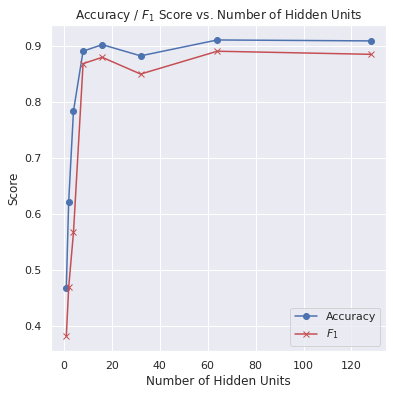

In [211]:
accs = [np.mean(perf['acc']) for perf in q11_perfs]
f1s = [np.mean(perf['f1']) for perf in q11_perfs]

if plotting:
    plt.figure(figsize=(6, 6))
    plt.plot(units, accs, 'bo-')
    plt.plot(units, f1s, 'rx-')
    plt.title('Accuracy / $F_1$ Score vs. Number of Hidden Units')
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Score')
    plt.legend(['Accuracy', '$F_1$'])
    plt.show()

One reason for the gap between accuracy and $F_1$ is that the $F_1$ score places more focus on true positives vs. false positives/negatives, so additional scoring due to true negatives are ignored.

## Q13

In [228]:
print('--- Logistic Regression: Vanilla ---')
print_metric('training time', q9_perf['time'], dp=5, unit='s')
print_metric('accuracy', q9_perf['acc'], dp=2, unit='%')
print_metric('F1', q9_perf['f1'], dp=2, unit='%')
print()
print('--- Logistic Regression: FNN ---')
max_array = lambda arr: max(arr, key=np.mean)
print_metric('training time', max_array(p['time'] for p in q11_perfs), dp=3, unit='s')
print_metric('accuracy', max_array(p['acc'] for p in q11_perfs), dp=1, unit='%')
print_metric('F1', max_array(p['f1'] for p in q11_perfs), dp=1, unit='%')


--- Logistic Regression: Vanilla ---
 - training time        µ=0.02992s   / std=0.00088s
 - accuracy             µ=93.17%     / std=0.24%
 - F1                   µ=91.55%     / std=0.27%

--- Logistic Regression: FNN ---
 - training time        µ=0.523s     / std=0.079s
 - accuracy             µ=91.0%      / std=1.9%
 - F1                   µ=89.0%      / std=2.0%


Overall the vanilla logistic regression model using `SGDClassifier` performed better in all metrics, including having a lower variance.

## Q14

Referring to the graph from Q12, it appears that for small number of hidden units (1, 2, 4), the model isn't really accurate. This may again be due to underfitting, as going from ninety-ish input features to just 4 is quite demanding for a model and it doesn't have sufficient parameters to handle all the various cases.

On the flip side, the model is pretty accurate when more hidden units are added, as the additional parameters can handle different cases better.

# Part 5: Hyperparameter Tuning

## Q15

We'll first use `GridSearchCV` to exhaustively test all combinations. I'm curious about the different solvers and learning rates. I'm also interested in trying non-uniform hidden unit sizes (e.g. first hidden layer has 32, second hidden layer has 16, etc.).

We'll use the `cv=5` parameter for 5-fold cross validation and `scoring='accuracy'` to rank models based on their accuracy.

In [175]:
from sklearn.model_selection import GridSearchCV

units = [16, 32, 64, 128]
param_grid = [
    {
        'solver': ['adam'],
        'learning_rate_init': [0.0001, 0.001, 0.01],
        'hidden_layer_sizes': [(h, h, h) for h in units] + [(h, h // 2, h // 4) for h in units],
    },
    # {
    #     'solver': ['sgd'],
    #     'learning_rate': ['constant'], 
    #     'learning_rate_init': [0.001, 0.01, 0.1],
    #     'hidden_layer_sizes': [(h, h, h) for h in units],
    # },
    {
        'solver': ['sgd'],
        'learning_rate': ['invscaling'],
        'learning_rate_init': [0.01, 0.1, 0.5],
        'power_t': [0.5, 0.05],
        'hidden_layer_sizes': [(h, h, h) for h in units] + [(h, h // 2, h // 4) for h in units],
    },
    {
        'solver': ['sgd'],
        'learning_rate': ['adaptive'],
        'learning_rate_init': [0.01, 0.1, 0.5],
        'hidden_layer_sizes': [(h, h, h) for h in units] + [(h, h // 2, h // 4) for h in units],
    },
]

default_params = {
    'max_iter': 500,
    'early_stopping': True,
    'random_state': 4211,
}

est = MLPClassifier(**default_params)
gscv = GridSearchCV(est, param_grid, cv=5, scoring='accuracy')

gscv.fit(X_train.to_numpy(), y_train['label'])

print(gscv.best_params_)


{'hidden_layer_sizes': (32, 32, 32), 'learning_rate': 'invscaling', 'learning_rate_init': 0.5, 'power_t': 0.05, 'solver': 'sgd'}


After fitting with our original training data, `X_train`, we can look at all the different models that `GridSearchCV` has tried by looking at `gscv.cv_results_`.

In [230]:
df = pd.DataFrame(gscv.cv_results_)

# Drop unneeded columns.
df = df.drop(['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score'], axis=1)

# Sort by rank and get top 10 rows.
top10 = df.sort_values('rank_test_score').iloc[:10]
top10['params'].apply(lambda d: d.update(default_params))
top10
# df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,param_learning_rate_init,param_solver,param_learning_rate,param_power_t,params,mean_test_score,std_test_score,rank_test_score
35,0.176043,0.020184,0.001230,0.000012,"(32, 32, 32)",0.5,sgd,invscaling,0.05,"{'hidden_layer_sizes': (32, 32, 32), 'learning...",0.941,0.018000,1
57,0.118754,0.011841,0.001051,0.000041,"(32, 16, 8)",0.1,sgd,invscaling,0.05,"{'hidden_layer_sizes': (32, 16, 8), 'learning_...",0.938,0.018601,2
74,1.428868,0.329683,0.001791,0.001418,"(16, 16, 16)",0.5,sgd,adaptive,NaN,"{'hidden_layer_sizes': (16, 16, 16), 'learning...",0.938,0.022494,2
11,0.389203,0.041961,0.002505,0.000079,"(128, 128, 128)",0.01,adam,NaN,NaN,"{'hidden_layer_sizes': (128, 128, 128), 'learn...",0.938,0.016000,2
77,1.319191,0.029873,0.001265,0.000065,"(32, 32, 32)",0.5,sgd,adaptive,NaN,"{'hidden_layer_sizes': (32, 32, 32), 'learning...",0.937,0.014353,5
73,0.816978,0.058836,0.001077,0.000050,"(16, 16, 16)",0.1,sgd,adaptive,NaN,"{'hidden_layer_sizes': (16, 16, 16), 'learning...",0.936,0.020347,6
29,0.126537,0.006735,0.001112,0.000162,"(16, 16, 16)",0.5,sgd,invscaling,0.05,"{'hidden_layer_sizes': (16, 16, 16), 'learning...",0.935,0.020000,7
27,0.148354,0.042331,0.001002,0.000026,"(16, 16, 16)",0.1,sgd,invscaling,0.05,"{'hidden_layer_sizes': (16, 16, 16), 'learning...",0.935,0.019748,7
63,0.168524,0.033972,0.001381,0.000012,"(64, 32, 16)",0.1,sgd,invscaling,0.05,"{'hidden_layer_sizes': (64, 32, 16), 'learning...",0.935,0.017607,7
47,0.393912,0.050393,0.002453,0.000094,"(128, 128, 128)",0.5,sgd,invscaling,0.05,"{'hidden_layer_sizes': (128, 128, 128), 'learn...",0.934,0.017720,10


As can be seen above, the best model in this case used the `sgd` (Stochastic Gradient Descent) solver along with `learning_rate='invscaling'`. Surprisingly, not too many hidden units were needed, just 32 per layer.

The models with decreasing number of hidden units (e.g. `(32, 16, 8)` performed okay-ish, which was a bit disappointing.

## Q16

In [234]:
top3 = top10.iloc[:3]
print('--- Best Settings ---')
for i, p in enumerate(top3['params']):
  print(f'#{i}:', ', '.join(f'{k}: {v}' for k, v in p.items()))

print('--- Best Scores ---')
top3[['mean_test_score', 'std_test_score']]

--- Best Settings ---
#0: hidden_layer_sizes: (32, 32, 32), learning_rate: invscaling, learning_rate_init: 0.5, power_t: 0.05, solver: sgd, max_iter: 500, early_stopping: True, random_state: 4211
#1: hidden_layer_sizes: (32, 16, 8), learning_rate: invscaling, learning_rate_init: 0.1, power_t: 0.05, solver: sgd, max_iter: 500, early_stopping: True, random_state: 4211
#2: hidden_layer_sizes: (16, 16, 16), learning_rate: adaptive, learning_rate_init: 0.5, solver: sgd, max_iter: 500, early_stopping: True, random_state: 4211
--- Best Scores ---


,mean_test_score,std_test_score
35,0.941,0.018000
57,0.938,0.018601
74,0.938,0.022494


## Q17

Metrics:
 - accuracy             92.4%
 - F1                   90.5%



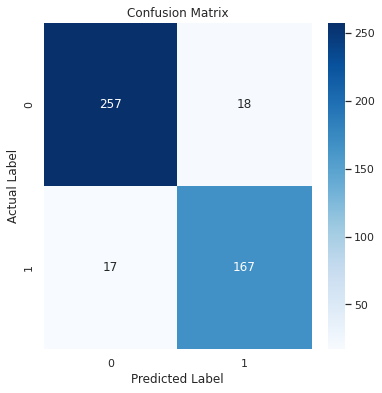

In [236]:
from sklearn.metrics import confusion_matrix

# Get best model.
model = gscv.best_estimator_

# Train model.
y_true = y_test['label']
y_pred = model.predict(X_test.to_numpy())
scores = logistic_metrics(y_true, y_pred)

# Metrixxxxx!
print('Metrics:')
print_metric('accuracy', scores['acc'], dp=1, unit='%')
print_metric('F1', scores['f1'], dp=1, unit='%')
print()

# Report confusion matrix.
cnf_matrix = confusion_matrix(y_true, y_pred)
if plotting:
    plt.figure(figsize=(6, 6))
    sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Part 6: Comparison of Classification Models

## Q18

An advantage of SGD is that it uses the gradient. However, a disadvantage is that it is unable to differentiate the learning rate between different features, so all weights update with the same learning rate.

FNNs, on the other hand, add hidden layers and therefore more parameters. This may make it fit better.